In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [76]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Load the data

In [4]:
# file paths
train_path = "../data/preprocessed/train_vectors_scaled.csv"
valid_path = "../data/preprocessed/validation_vectors_scaled.csv"
test_path = "../data/preprocessed/test_vectors_scaled.csv"
gen_path = "../data/preprocessed/generalisation_vectors_scaled.csv"

In [5]:
# load the dataframes
train_df = pd.read_csv(train_path)
valid_df = pd.read_csv(valid_path)
test_df = pd.read_csv(test_path)
gen_df = pd.read_csv(gen_path)

In [15]:
def preprocess(df, label_encoder = None):
    # get target features
    data_df = df.drop(columns=['Type'])
    if "is_synthetic" in data_df.columns:
        data_df.drop(columns=['is_synthetic'], inplace = True)
    data_df = data_df.reindex(sorted(data_df.columns), axis=1)
    target_df = df['Type']

    # encode target labels
    if label_encoder is None:
        label_encoder = LabelEncoder()
        label_encoder.fit(target_df)
    target_df = label_encoder.transform(target_df)

    X = data_df.to_numpy()
    y = target_df

    return X, y, label_encoder

In [83]:
# preprocess the datasets
X_train_, y_train_, target_label_encoder =  preprocess(train_df)
X_valid_, y_valid_, _ =  preprocess(valid_df, label_encoder=target_label_encoder)
X_test, y_test, _ =  preprocess(test_df, label_encoder=target_label_encoder)
X_gen, y_gen, _ =  preprocess(gen_df, label_encoder=target_label_encoder)

In [84]:
print(X_train_.shape, X_valid_.shape, X_test.shape, X_gen.shape)

(1346829, 24) (1247266, 24) (1233449, 24) (2452610, 24)


In [90]:
y_train_.shape

(1346829,)

In [91]:
y_valid_.shape

(1247266,)

In [93]:
np.concatenate((y_train_, y_valid_)).shape

(2594095,)

In [94]:
# train test split
merge_X = np.vstack((X_train_,X_valid_))
merge_Y = np.concatenate((y_train_, y_valid_))

X_train, X_valid, y_train, y_valid = train_test_split(merge_X, merge_Y, test_size=0.2, random_state=42)

# Train the model

In [95]:
# Initialize XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42, n_estimators = 500)

# Train the classifier on the training data and evaluate on the validation set
xgb_classifier.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric=['merror'], early_stopping_rounds=10)

c:\Users\Maya\.conda\envs\ddos\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Maya\.conda\envs\ddos\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-merror:0.15315
[1]	validation_0-merror:0.15620
[2]	validation_0-merror:0.15598
[3]	validation_0-merror:0.15099
[4]	validation_0-merror:0.14656
[5]	validation_0-merror:0.14544
[6]	validation_0-merror:0.13063
[7]	validation_0-merror:0.13040
[8]	validation_0-merror:0.12914
[9]	validation_0-merror:0.12853
[10]	validation_0-merror:0.12639
[11]	validation_0-merror:0.12529
[12]	validation_0-merror:0.12453
[13]	validation_0-merror:0.12300
[14]	validation_0-merror:0.12288
[15]	validation_0-merror:0.12206
[16]	validation_0-merror:0.12107
[17]	validation_0-merror:0.12104
[18]	validation_0-merror:0.12034
[19]	validation_0-merror:0.11953
[20]	validation_0-merror:0.11923
[21]	validation_0-merror:0.11845
[22]	validation_0-merror:0.11711
[23]	validation_0-merror:0.11633
[24]	validation_0-merror:0.11449
[25]	validation_0-merror:0.11396
[26]	validation_0-merror:0.11239
[27]	validation_0-merror:0.11212
[28]	validation_0-merror:0.11151
[29]	validation_0-merror:0.11144
[30]	validation_0-me

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

Accuracy: 0.8494506055783417


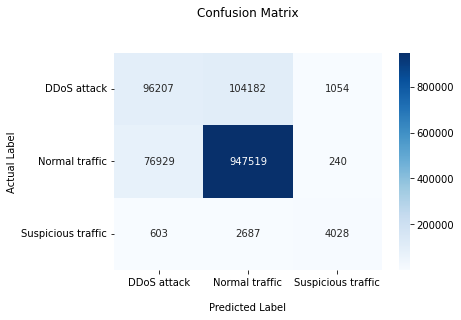

In [96]:
# Make predictions on the test data
y_pred = xgb_classifier.predict(X_test)

# Calculate accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

cf_matrix = confusion_matrix(y_test, y_pred)

class_names = target_label_encoder.inverse_transform([0,1,2])

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt = 'd', xticklabels=class_names, yticklabels=class_names)

ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('Actual Label')

## Display the visualization of the Confusion Matrix.
plt.show()

In [45]:
print(np.unique(y_train, return_counts=True)[1] / len(y_train))
print(np.unique(y_valid, return_counts=True)[1] / len(y_valid))
print(np.unique(y_test, return_counts=True)[1] / len(y_test))
print(np.unique(y_gen, return_counts=True)[1] / len(y_gen))

[0.33333333 0.33333333 0.33333333]
[0.24466874 0.7369687  0.01836256]
[0.16331685 0.8307502  0.00593296]
[0.26188917 0.57957074 0.15854009]


Accuracy: 0.921207106910117


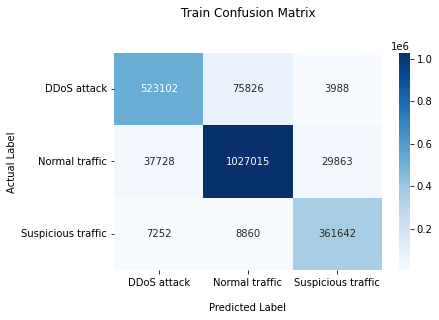

In [100]:
# Make predictions on the test data
y_pred = xgb_classifier.predict(X_train)

# Calculate accuracy of the model
accuracy = accuracy_score(y_train, y_pred)
print("Accuracy:", accuracy)

cf_matrix = confusion_matrix(y_train, y_pred)

class_names = target_label_encoder.inverse_transform([0,1,2])

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt = 'd', xticklabels=class_names, yticklabels=class_names)

ax.set_title('Train Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('Actual Label')

## Display the visualization of the Confusion Matrix.
plt.show()

Accuracy: 0.9175512076465974


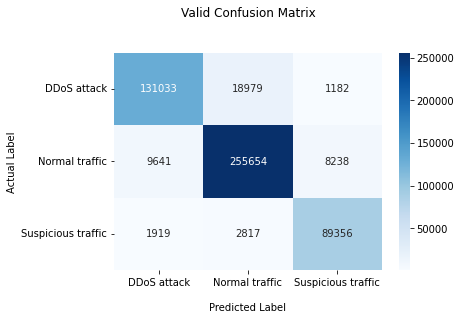

In [101]:
# Make predictions on the test data
y_pred = xgb_classifier.predict(X_valid)

# Calculate accuracy of the model
accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy:", accuracy)

cf_matrix = confusion_matrix(y_valid, y_pred)

class_names = target_label_encoder.inverse_transform([0,1,2])

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt = 'd', xticklabels=class_names, yticklabels=class_names)

ax.set_title('Valid Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('Actual Label')

## Display the visualization of the Confusion Matrix.
plt.show()

Accuracy: 0.8494506055783417


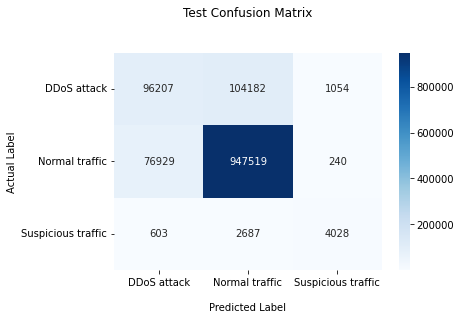

In [103]:
# Make predictions on the test data
y_pred = xgb_classifier.predict(X_test)

# Calculate accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

cf_matrix = confusion_matrix(y_test, y_pred)

class_names = target_label_encoder.inverse_transform([0,1,2])

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt = 'd', xticklabels=class_names, yticklabels=class_names)

ax.set_title('Test Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('Actual Label')

## Display the visualization of the Confusion Matrix.
plt.show()

Accuracy: 0.7529325901794415


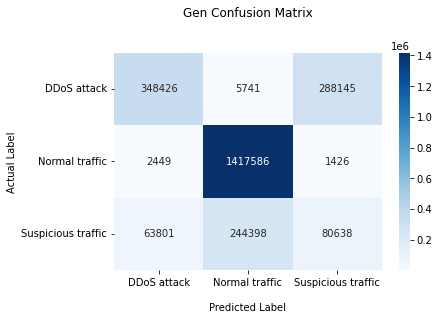

In [104]:
# Make predictions on the test data
y_pred = xgb_classifier.predict(X_gen)

# Calculate accuracy of the model
accuracy = accuracy_score(y_gen, y_pred)
print("Accuracy:", accuracy)

cf_matrix = confusion_matrix(y_gen, y_pred)

class_names = target_label_encoder.inverse_transform([0,1,2])

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt = 'd', xticklabels=class_names, yticklabels=class_names)

ax.set_title('Gen Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('Actual Label')

## Display the visualization of the Confusion Matrix.
plt.show()

In [64]:
feature_importance= xgb_classifier.feature_importances_

# Map feature importance scores to feature names

feature_names = train_df.reindex(sorted(train_df.columns), axis=1).drop(columns=['Type', 'is_synthetic']).columns
feature_importance_map = dict(zip(feature_names, feature_importance))

# Sort feature importance scores
sorted_feature_importance = sorted(feature_importance_map.items(), key=lambda x: x[1], reverse=True)

# Print feature importance scores
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")

High volume traffic: 0.39099767804145813
Suspicious traffic: 0.15317358076572418
victim IP num: 0.13724973797798157
Significant flag: 0.07377023249864578
Avg packet len: 0.05506071820855141
CLDAP: 0.04448249191045761
Source IP count: 0.031933121383190155
Port number: 0.030810993164777756
Generic UDP: 0.017998188734054565
Data speed: 0.017854852601885796
DNS: 0.01346905529499054
time_of_day: 0.013193248771131039
is_weekday: 0.007203258108347654
NTP: 0.004250317346304655
Packet speed: 0.0034009015653282404
IPv4 fragmentation: 0.0023525631986558437
CoAP: 0.002037700032815337
SYN Attack: 0.000728628714568913
SNMP: 3.2814750738907605e-05
CHARGEN: 0.0
RDP: 0.0
SSDP: 0.0
TCP Anomaly: 0.0
other_attack_codes: 0.0
